In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
dir_baseline = '../checkpoints/result/'
dir_R_sK = '../checkpoints/result_density_rgbW/'
dir_A_sK = '../checkpoints/result_de/'
dir_A_sD = '../checkpoints/result_dd/'
datasets = ['Beauty', 'HoneyBee', 'Jockey']

In [15]:
def parse_train_txt(train_txt_path):
    with open(train_txt_path, 'r') as file:
        lines = file.readlines()
        last_line = lines[-1].strip()
        data = last_line.split(',')
        result = {
            'PSNR': float(data[1].split(':')[-1]),
            'MS-SSIM': float(data[2].split(':')[-1]),
            'Training': float(data[3].split(':')[-1][:-1]),
            'Eval': float(data[4].split(':')[-1][:-1]),
            'FPS': float(data[5].split(':')[-1]),
            'Size': float(data[6].split(':')[-1]),
            'Gaussian_number':float(data[-1].split(':')[-1])
        }    
    return result

In [16]:
def get_method_data(dir_path):
    results = []
    for dataset in datasets:
        dataset_path = os.path.join(dir_path, dataset)
        for dir_name in os.listdir(dataset_path):
            if dir_name.startswith('GaussianImage_Cholesky'):
                train_txt_path = os.path.join(dataset_path, dir_name, 'train.txt')
                result= parse_train_txt(train_txt_path)
                result['Dataset'] = dataset
                # if result['Gaussian_number']<=30000:
                if result['Gaussian_number']>5000:
                    results.append(result)
    return results

results_baseline = get_method_data(dir_baseline)
results_R_sK=get_method_data(dir_R_sK)
results_A_sK=get_method_data(dir_A_sK)
results_A_sD=get_method_data(dir_A_sD)
df_baseline = pd.DataFrame(results_baseline)
df_R_sK = pd.DataFrame(results_R_sK)
df_A_sK = pd.DataFrame(results_A_sK)
df_A_sD = pd.DataFrame(results_A_sD)

In [17]:
def plot_gaussian_vs_metrics(df_baseline,df_R_sK,df_A_sK,df_A_sD):
        #color_palette = plt.cm.get_cmap('tab10', 6)
        color_palette = ['#377eb8',  '#4daf4a', '#984ea3', '#e41a1c', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
        datasets_info = [
                ('Baseline (Static K-frame selection)', df_baseline),
                ('Removal control (Static K-frame selection)', df_R_sK),
                ('Adaptive control (Static K-frame selection)', df_A_sK),
                # ('Adaptive control (Scene Detector)', df_A_sD),
        ]

        for dataset in datasets:
                sorted_datasets = []
                for label, df in datasets_info:
                        sorted_datasets.append((label, df[df['Dataset'] == dataset].sort_values(by='Gaussian_number')))

                        plt.figure(figsize=(11, 5))
                        plt.subplot(1, 2, 1)
                        for i, (label, subset_df) in enumerate(sorted_datasets):
                                # Scatter plot
                                plt.scatter(subset_df['Gaussian_number'], subset_df['PSNR'], 
                                                color=color_palette[i], s=50, label=label, edgecolor='black')
                                # Line plot
                                plt.plot(subset_df['Gaussian_number'], subset_df['PSNR'], 
                                        color=color_palette[i])
                                

                        plt.xlabel('Gaussian Number', fontsize=14, fontweight='bold')
                        plt.ylabel('PSNR (dB)', fontsize=14, fontweight='bold')
                        plt.title(f'{dataset} - Gaussian Number vs PSNR', fontsize=16, fontweight='bold')
                        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                        plt.legend()

                        plt.subplot(1, 2, 2)
                        for i, (label, subset_df) in enumerate(sorted_datasets):
                                # Scatter plot
                                plt.scatter(subset_df['Gaussian_number'], subset_df['MS-SSIM'], 
                                                color=color_palette[i], s=50, label=label, edgecolor='black')
                                # Line plot
                                plt.plot(subset_df['Gaussian_number'], subset_df['MS-SSIM'], 
                                        color=color_palette[i])

                        plt.xlabel('Gaussian Number', fontsize=14, fontweight='bold')
                        plt.ylabel('MS-SSIM', fontsize=14, fontweight='bold')
                        plt.title(f'{dataset} - Gaussian Number vs MS-SSIM', fontsize=16, fontweight='bold')
                        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                        plt.legend()
                        plt.tight_layout()
                        plt.savefig(f'./img_compare/{dataset}_gaussian_vs_metrics.png')
                        plt.show()


In [18]:
import matplotlib.pyplot as plt

def plot_average_gaussian_vs_metrics(df_baseline,df_R_sK,df_A_sK,df_A_sD):
    #color_palette = plt.cm.get_cmap('tab10', 6)
    color_palette = ['#377eb8',  '#4daf4a', '#984ea3', '#e41a1c', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
    datasets_info = [
                ('Baseline (Static K-frame selection)', df_baseline),
                ('Removal control (Static K-frame selection)', df_R_sK),
                ('Adaptive control (Static K-frame selection)', df_A_sK),
                # ('Adaptive control (Scene Detector)', df_A_sD),
        ]
    
    metrics = ['PSNR', 'MS-SSIM']
    metric_labels = ['PSNR (dB)', 'MS-SSIM']
    
    for metric, metric_label in zip(metrics, metric_labels):
        plt.figure(figsize=(8, 6))
        
        for i, (label, df) in enumerate(datasets_info):
            # 按 Gaussian 数量进行分组，并计算每个 Gaussian 数量的均值
            df_mean = df.groupby('Gaussian_number')[metric].mean().reset_index()
            
            # 绘制每个方法的折线图
            plt.plot(df_mean['Gaussian_number'], df_mean[metric], 
                     color=color_palette[i], label=label, linewidth=2)
            
            # # 添加数据点
            # plt.scatter(df_mean['Gaussian_number'], df_mean[metric], 
            #             color=color_palette[i], s=50, edgecolor='black')

        plt.xlabel('Gaussian Number', fontsize=14, fontweight='bold')
        plt.ylabel(metric_label, fontsize=14, fontweight='bold')
        plt.title(f'Gaussian Number vs {metric_label}', fontsize=16, fontweight='bold')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend()
        plt.tight_layout()
        
        # 保存图像
        plt.savefig(f'./img_compare/Average_gaussian_vs_{metric}.png')
        plt.show()


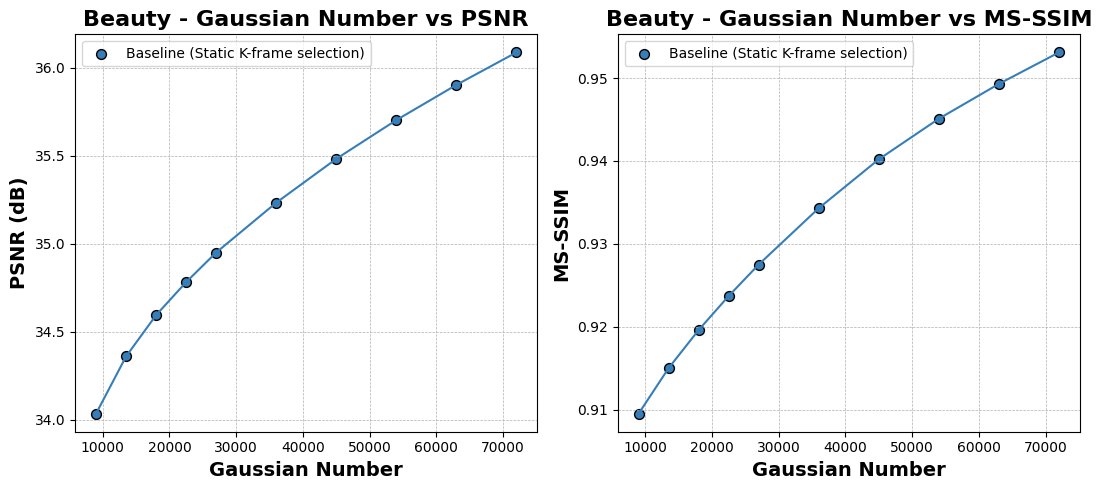

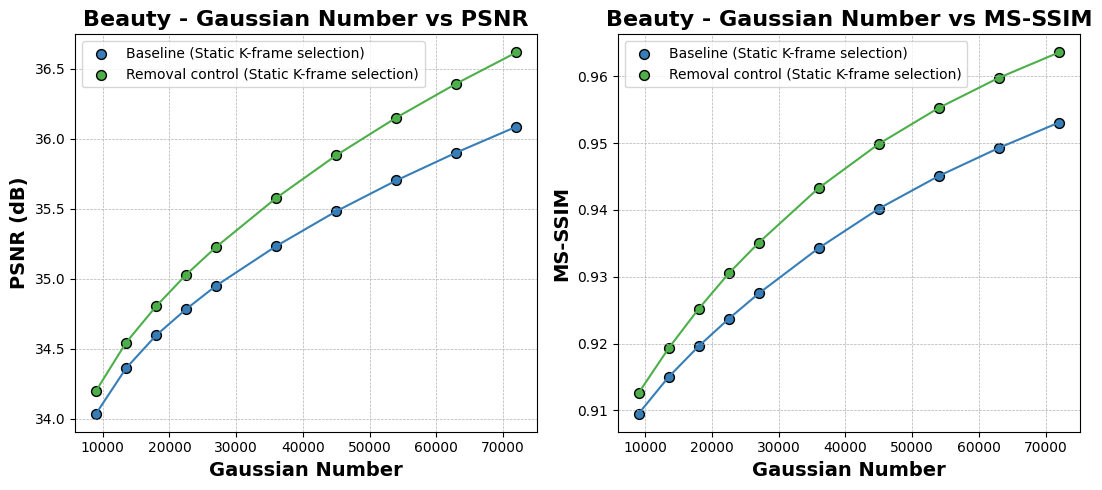

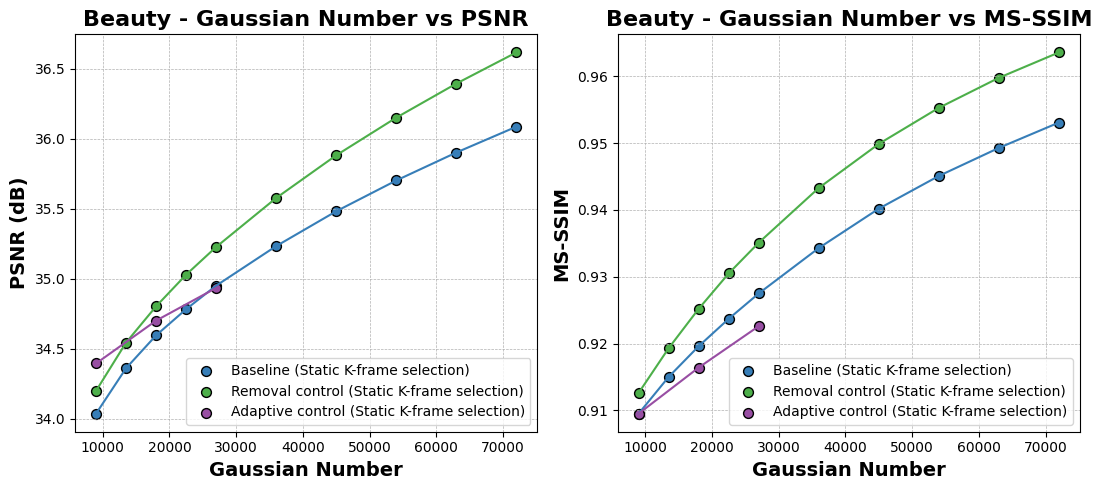

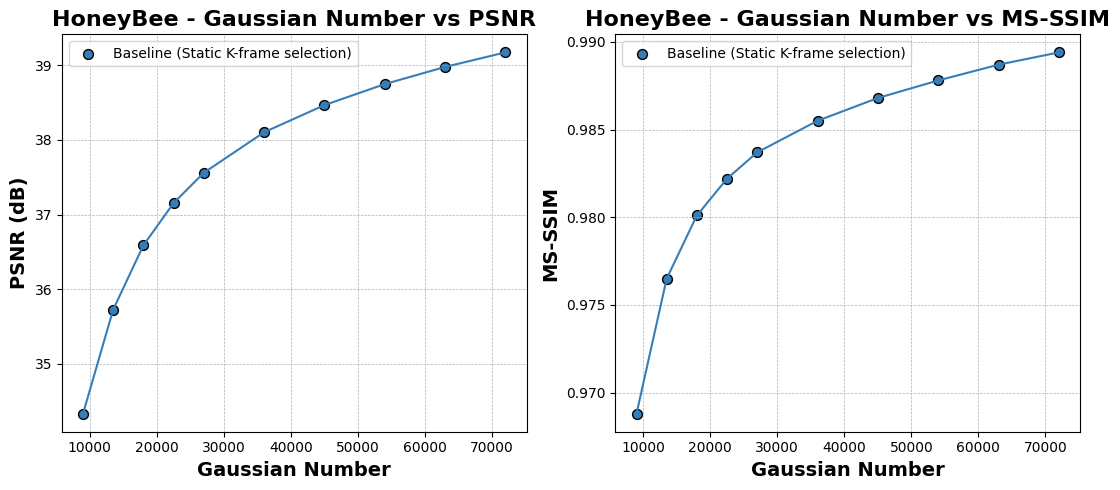

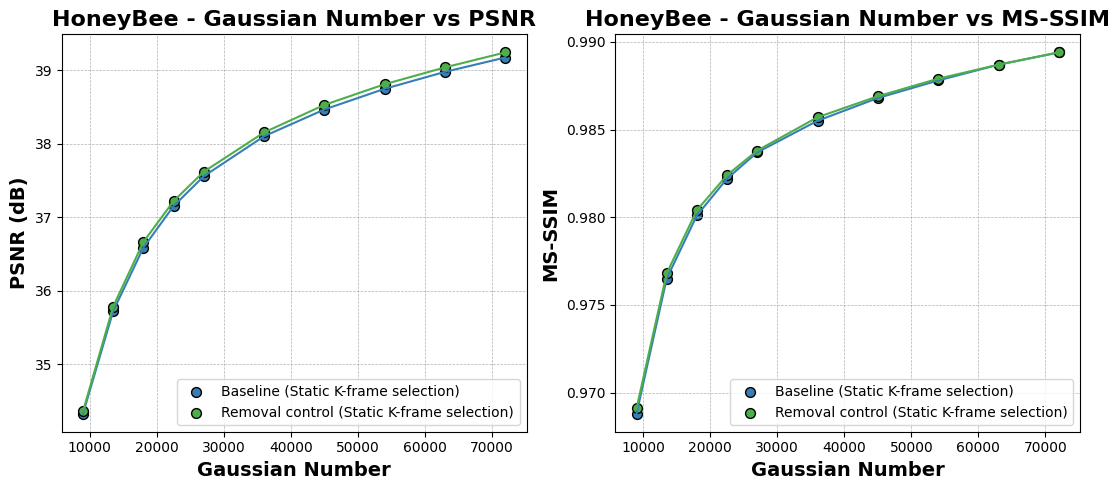

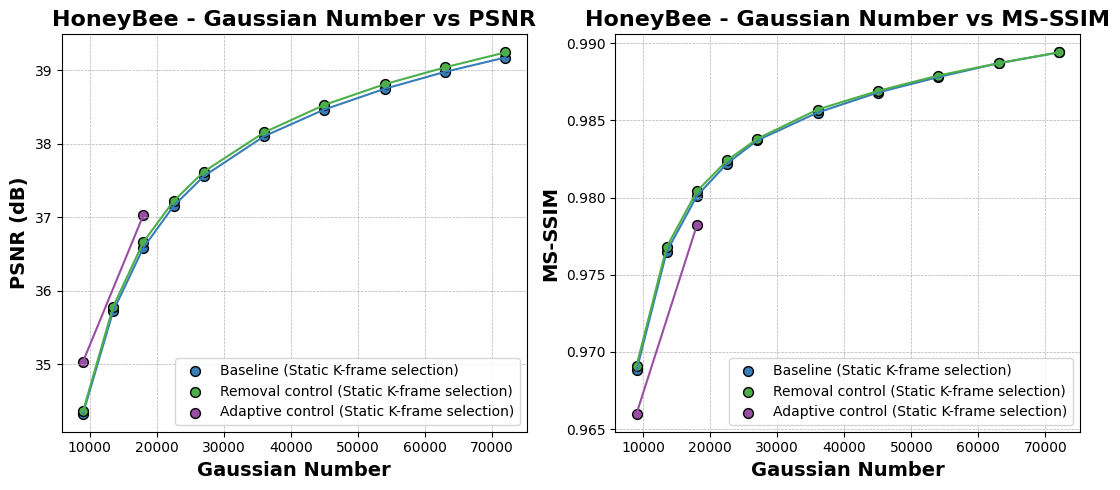

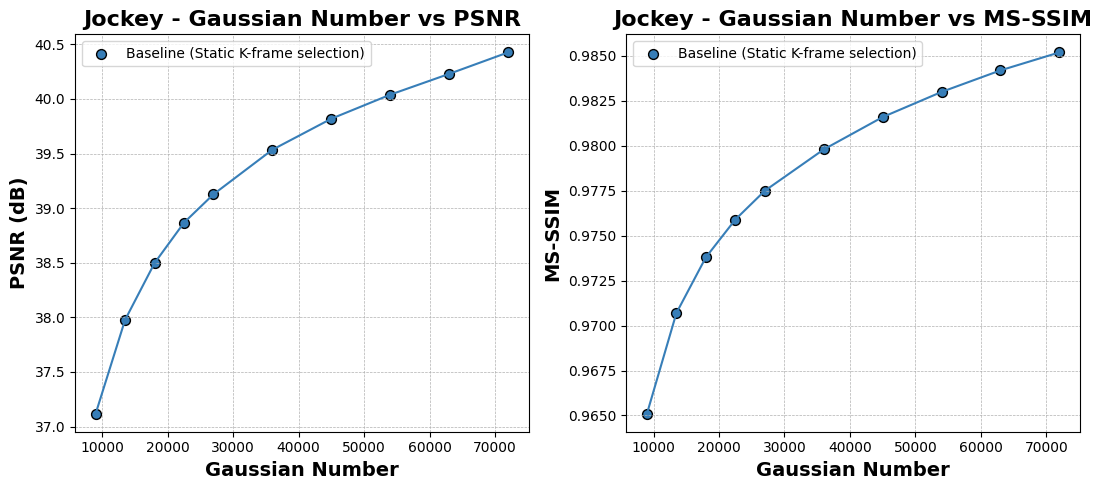

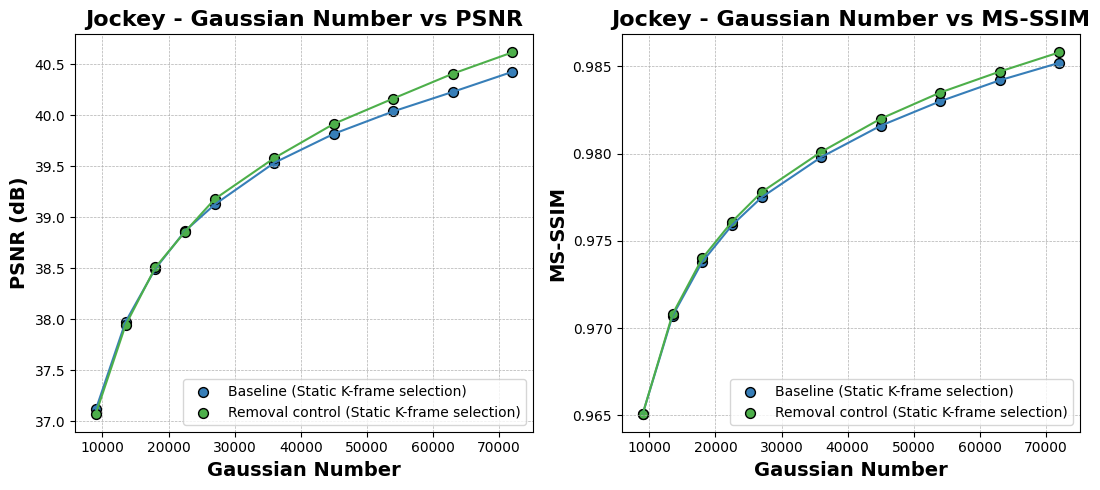

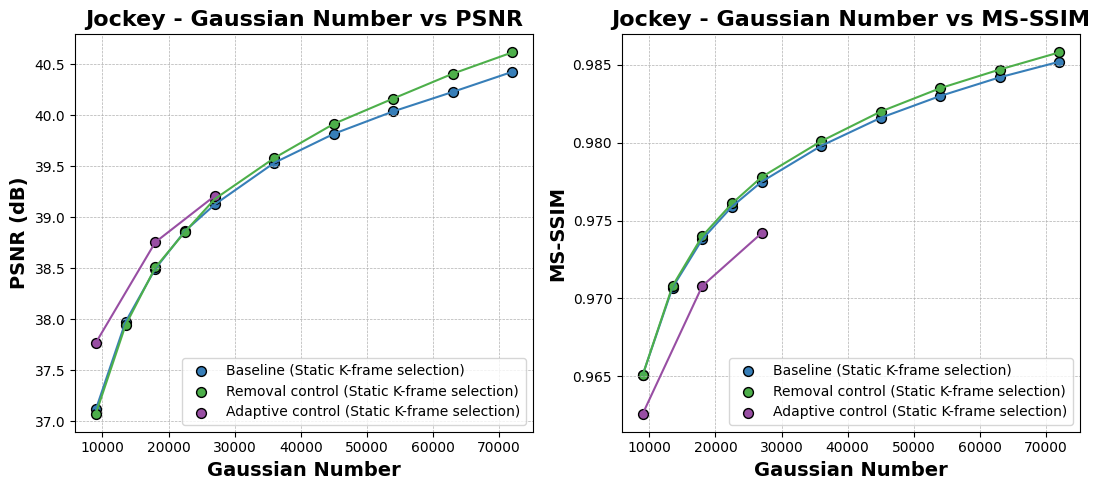

In [19]:
plot_gaussian_vs_metrics(df_baseline,df_R_sK,df_A_sK,df_A_sD)


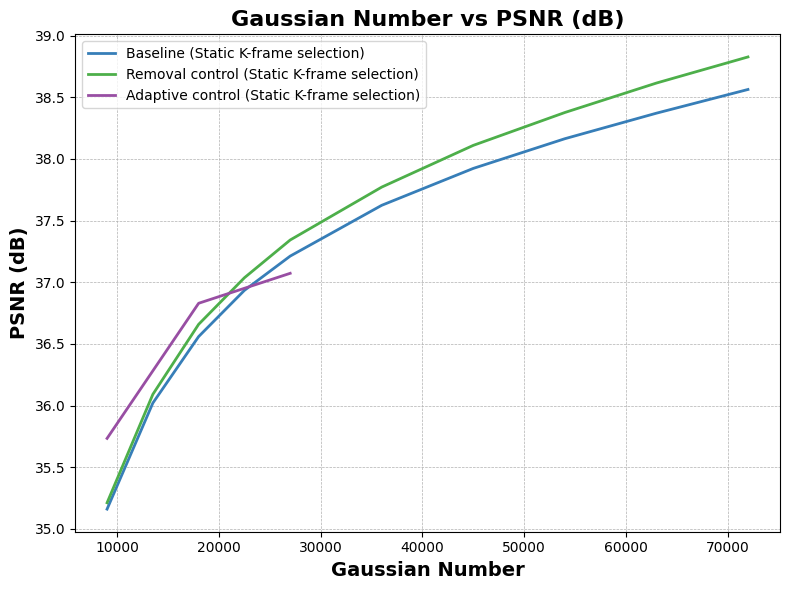

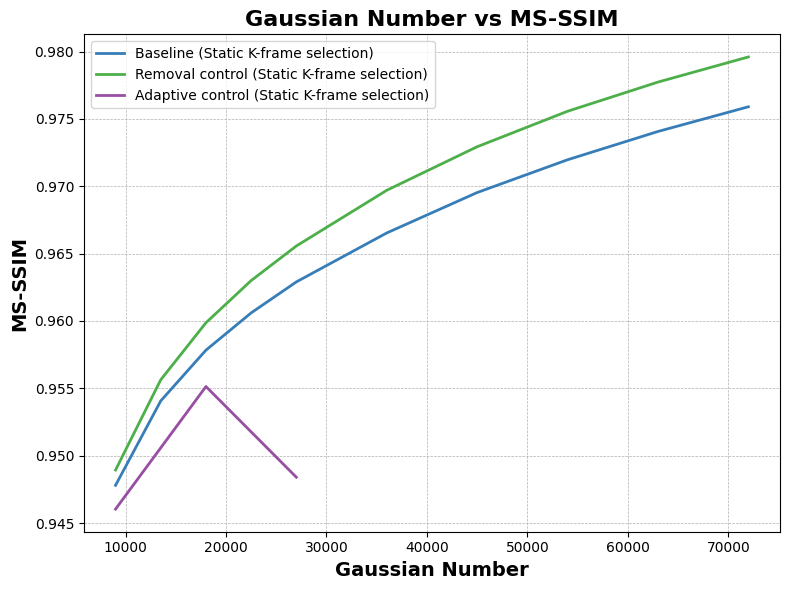

In [20]:
plot_average_gaussian_vs_metrics(df_baseline,df_R_sK,df_A_sK,df_A_sD)